# Проектная работа "Работа в DS"

**Выполнил:** Харисов Ильнур Шаукатович
2 курс ОП "Экономика" (БЭК221)

Цели: 
1. Изучить рынок труда в data science
2. Найти закономерности в том под влиянием каких факторов работодатели (IT и финтех компании) принимают решение о найме на позицию, чтобы применить данные знания в процессе построения карьеры

In [117]:
# les go

Импортируем требуемые для работы библиотеки

In [118]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

Считаем csv-файл, данные о рынке труда в DS взяты с Kaggle (https://www.kaggle.com/datasets/zain280/data-science-job/data)

In [119]:
df = pd.read_csv('data_science_job.csv')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,52.0,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,20.0,50-99,Funded Startup,8.0,0.0


In [120]:
df.shape

(19158, 13)

In [121]:
'''
Описание колонок датасета:

    0. enrollee_id               : уникальный id кандидата (ключ)
    1. city                      : код города кандидата
    2. city_development_index    : уровень развития города кандидата
    3. gender                    : пол кандидата
    4. relevent_experience       : флаг наличие релевантного опыта кандидата
    5. enrolled_university       : флаг прохождения тематического курса 
    6. education_level           : уровень образования кандидата
    7. major_discipline          : специальность кандидата в университете
    8. experience                : лет рабочего опыта кандидата
    9. company_size              : размер нанимающей организации
    10. company_type             : тип нанимающей организации
    11. training_hours           : часов практики, пройденных кандидатом
    12. target                   : флаг устройства на позицию
'''

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  18679 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  float64
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  training_hours          18392 non-null  float64
 12  target                  19158 non-null  float64
dtypes: float64(4), int64(1), object(8)
memory usage: 1.9+ MB


In [122]:
df.describe()

,enrollee_id,city_development_index,experience,training_hours,target
count,19158.000000,18679.000000,19093.000000,18392.000000,19158.000000
mean,16875.358179,0.828951,9.928036,65.185787,0.249348
std,9616.292592,0.123334,6.505268,59.885626,0.432647
min,1.000000,0.448000,0.000000,1.000000,0.000000
25%,8554.250000,0.740000,4.000000,23.000000,0.000000
50%,16982.500000,0.903000,9.000000,47.000000,0.000000
75%,25169.750000,0.920000,16.000000,88.000000,0.000000
max,33380.000000,0.949000,20.000000,336.000000,1.000000


In [123]:
df.isna().sum()

enrollee_id                  0
city                         0
city_development_index     479
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
training_hours             766
target                       0
dtype: int64

Много пропусков в колонках 'gender', 'company_size', 'company_type'

# Предварительныя обработка

### 1. Работа с неинформативными признаками

Удалим из таблицы ID кандидата, поскольку он не влияет на характеристику соискателя

In [124]:
df = df.drop('enrollee_id', axis=1)
df.head()

,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target
0,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0
1,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0
2,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0
3,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,0.0,NaN,Pvt Ltd,52.0,1.0
4,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,20.0,50-99,Funded Startup,8.0,0.0


Заметим, что в нашем датасете довольно много пропусков в колонках 'gender' 'company_size' 'company_type': их трудно заменить средним или медианой поскольку при этом теряется смысл (это будет слишком натянуто), поэтому избавимся от строк с нулевыми значениями в этих колонках

In [125]:
df = df.dropna(subset=['gender', 'company_size', 'company_type'])

display(df.shape)
df.isna().sum()

(9791, 12)

city                        0
city_development_index    240
gender                      0
relevent_experience         0
enrolled_university        72
education_level            79
major_discipline          745
experience                  6
company_size                0
company_type                0
training_hours            373
target                      0
dtype: int64

Получили размер выборки около 10к - нас это устраивает!

### 2. Устранение шума

Обратим внимание на признак город кандидата: там встречаются очень много уникальных значений городов, постараемся с этим что-то сделать

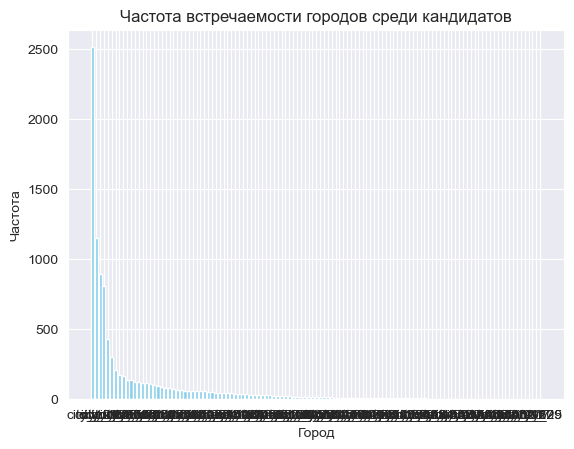

In [126]:
cities = df['city'].value_counts().reset_index()
plt.bar(cities['index'], cities['city'], color='skyblue')

plt.title('Частота встречаемости городов среди кандидатов')
plt.xlabel('Город')
plt.ylabel('Частота')

plt.show()

Распределение очень скошенное, можно вычистить непопулярные города, заменив значение например на 'other'

In [127]:
rare_cities = cities[cities['city'] < 40]['index'].tolist()
df.loc[df['city'].isin(rare_cities), 'city'] = 'other'

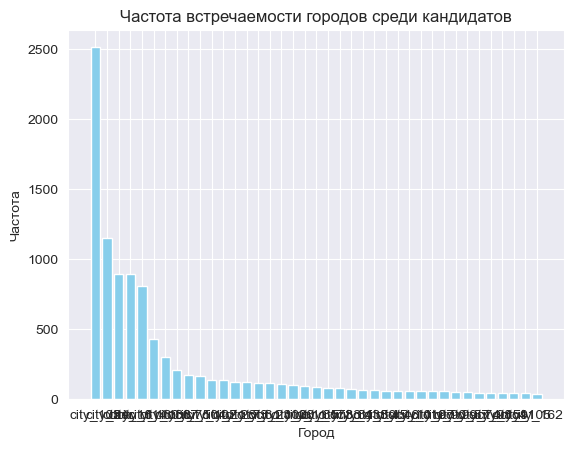

In [128]:
cities = df['city'].value_counts().reset_index()
plt.bar(cities['index'], cities['city'], color='skyblue')

plt.title('Частота встречаемости городов среди кандидатов')
plt.xlabel('Город')
plt.ylabel('Частота')

plt.show()

Городов стало меньше и мы снизили количество шума в данных

### 3. Трансформация

Проведем предобработку: 
- отскейлим числовые данные, заполним нулевые значения медианой
- для категориальных используем OHE, пропуски заполним самым часто встречающимся значением, дропнем первые столбцы чтобы избежать мультиколлениарности (новых значений в колонках мы не ожидаем)

In [129]:
X = df.drop('target', axis=1)
y = df['target']

In [130]:
categorical_features = X.select_dtypes(include=['object']).columns.tolist()
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('numeric', numeric_transformer, numeric_features),
        ('categorical', categorical_transformer, categorical_features)
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

X_train = preprocessor.fit_transform(X_train).toarray()
X_test = preprocessor.transform(X_test).toarray()

encoded_cat_columns = preprocessor.named_transformers_['categorical']['onehot'].get_feature_names_out(
    input_features=categorical_features)

X_train = pd.DataFrame(X_train, columns=(numeric_features + list(encoded_cat_columns)))
X_test = pd.DataFrame(X_test, columns=(numeric_features + list(encoded_cat_columns)))

# Визуализация

### 1. Таргет

Для начала посмотрим на распределение целевой переменной в наших данных

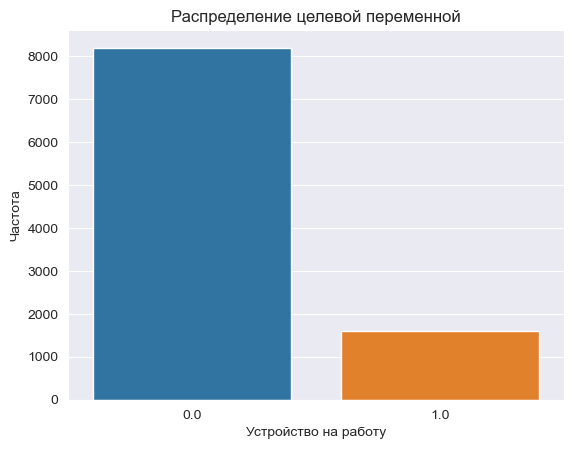

In [131]:
sns.countplot(x='target', data=df)

plt.title('Распределение целевой переменной')
plt.xlabel('Устройство на работу')
plt.ylabel('Частота')

plt.show()

Видим что на работу устроилась гораздо меньше людей чем подавалось, большинство соискателей не устроилось на позицию, что говорит о дисбалансе классов в наших данных

### 2. Пол

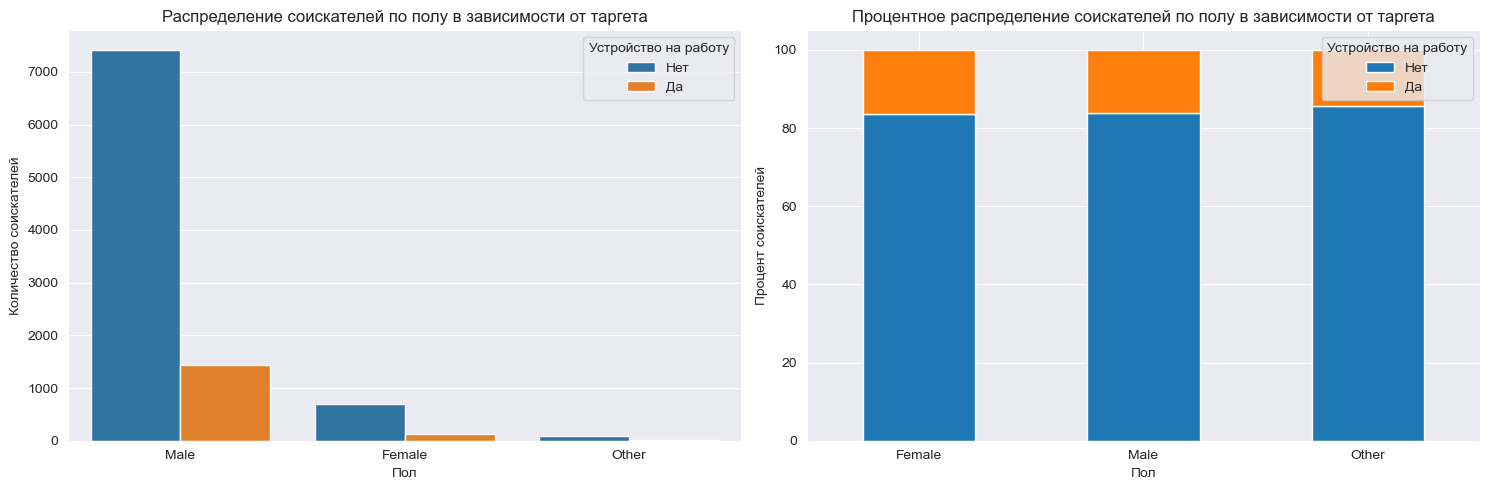

In [132]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='gender', hue='target', data=df)
plt.title('Распределение соискателей по полу в зависимости от таргета')
plt.xlabel('Пол')
plt.ylabel('Количество соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.subplot(1, 2, 2)
relevent_exp = df.groupby(['gender', 'target']).size().unstack(fill_value=0)
relevent_exp_percent = relevent_exp.div(relevent_exp.sum(axis=1), axis=0) * 100
relevent_exp_percent.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xticks(rotation=0)
plt.title('Процентное распределение соискателей по полу в зависимости от таргета')
plt.xlabel('Пол')
plt.ylabel('Процент соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.tight_layout()
plt.show()

Можем заметить что на позиции Data Science подавалось больше мужчин, чем женщин. Однако доля нанятых мужчин и женщин совпадают, поэтому можно делать вывод о том, что среди нанимателей отсутствует гендерная дискриминация

### 3. Город

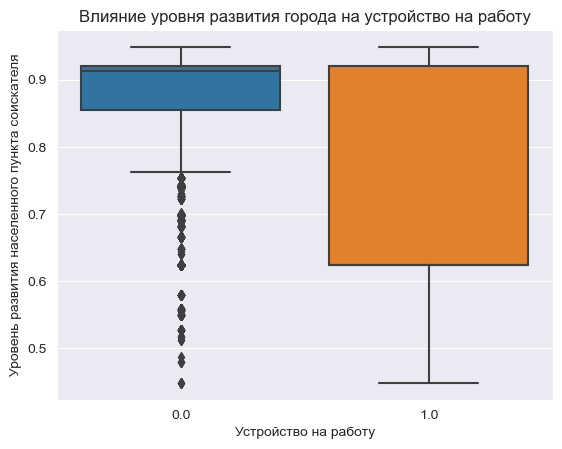

In [133]:
sns.boxplot(x='target', y='city_development_index', data=df)

plt.title('Влияние уровня развития города на устройство на работу')
plt.xlabel('Устройство на работу')
plt.ylabel('Уровень развития населенного пункта соискателя')

plt.show()

Из визуализации видно, что на позиции подавалось больше людей из развитых городов, однако на работу также активно брали людей из городов с низким уровнем развития. По сути это означает, что при том что из городов с высоким уровнем развития подавалось больше людей компании старались набирать людей равномерно. Таким образом возможно, что людям из маленьких городов удавалось проще попасть на позицию в Data Science.

### 4. Опыт

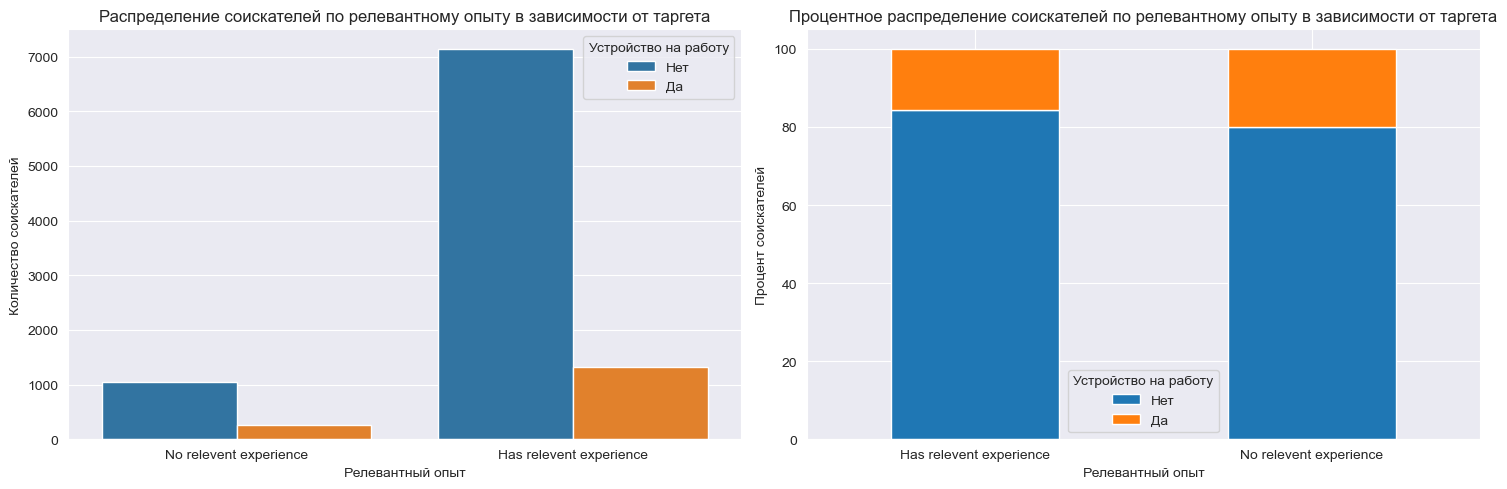

In [134]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='relevent_experience', hue='target', data=df)
plt.title('Распределение соискателей по релевантному опыту в зависимости от таргета')
plt.xlabel('Релевантный опыт')
plt.ylabel('Количество соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.subplot(1, 2, 2)
relevent_exp = df.groupby(['relevent_experience', 'target']).size().unstack(fill_value=0)
relevent_exp_percent = relevent_exp.div(relevent_exp.sum(axis=1), axis=0) * 100
relevent_exp_percent.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xticks(rotation=0)
plt.title('Процентное распределение соискателей по релевантному опыту в зависимости от таргета')
plt.xlabel('Релевантный опыт')
plt.ylabel('Процент соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.tight_layout()
plt.show()

Теперь мы видим данных странное противоречие: соискатели, у которых не было релевантного опыта, были наняты чаще, чем те у кого релевантный опыт имелся. Однако вряд ли это различие значимо.

### 5. Образование

In [135]:
list(df['education_level'].unique())

['Graduate', 'Masters', 'High School', 'Phd', nan, 'Primary School']

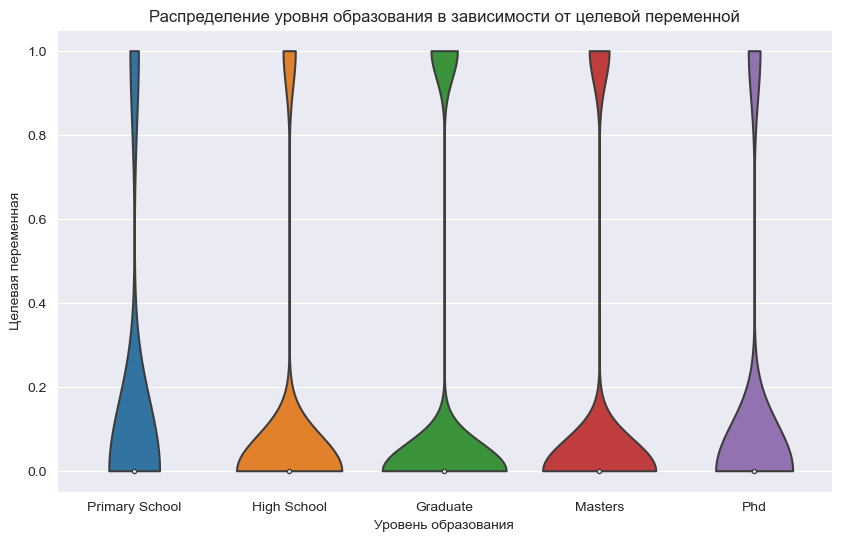

In [136]:
ordered_education_levels = ['Primary School', 'High School', 'Graduate', 'Masters', 'Phd']
df['education_level'] = pd.Categorical(df['education_level'], categories=ordered_education_levels, ordered=True)

plt.figure(figsize=(10, 6))

sns.violinplot(x='education_level', y='target', data=df, cut=0)
plt.title('Распределение уровня образования в зависимости от целевой переменной')
plt.xlabel('Уровень образования')
plt.ylabel('Целевая переменная')

plt.show()

В нашем датасете больше всего соискателей получили степень бакалавра, а тех кто закончил среднюю школу можно встретить наиболее редко

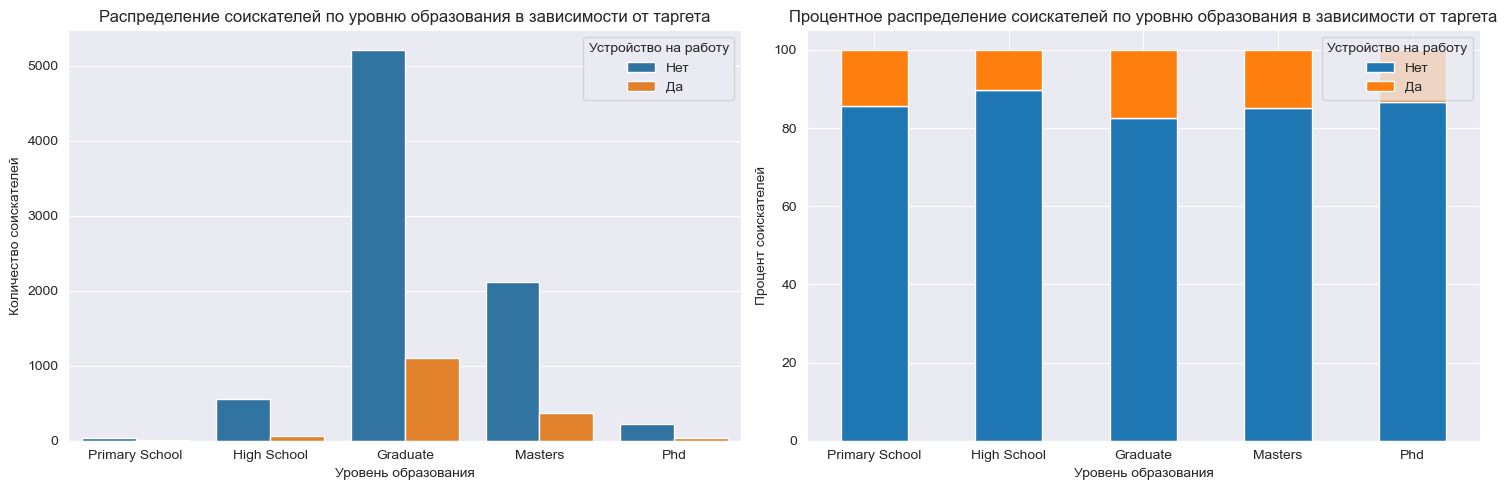

In [137]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='education_level', hue='target', data=df)
plt.title('Распределение соискателей по уровню образования в зависимости от таргета')
plt.xlabel('Уровень образования')
plt.ylabel('Количество соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.subplot(1, 2, 2)
relevent_exp = df.groupby(['education_level', 'target']).size().unstack(fill_value=0)
relevent_exp_percent = relevent_exp.div(relevent_exp.sum(axis=1), axis=0) * 100
relevent_exp_percent.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xticks(rotation=0)
plt.title('Процентное распределение соискателей по уровню образования в зависимости от таргета')
plt.xlabel('Уровень образования')
plt.ylabel('Процент соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.tight_layout()
plt.show()

Из графика кажется, что наибольший шанс устроиться есть у тех людей, кто только что получил степень бакалавра.
Тем кто ещё не закончил высшую школу отказывали чаще всего, что говорит о не готовности работодателей принимать на работу людей, которые в текущий момент проходят обучение в вузе

In [138]:
list(df['major_discipline'].unique())

['STEM', nan, 'Humanities', 'Business Degree', 'Other', 'No Major', 'Arts']

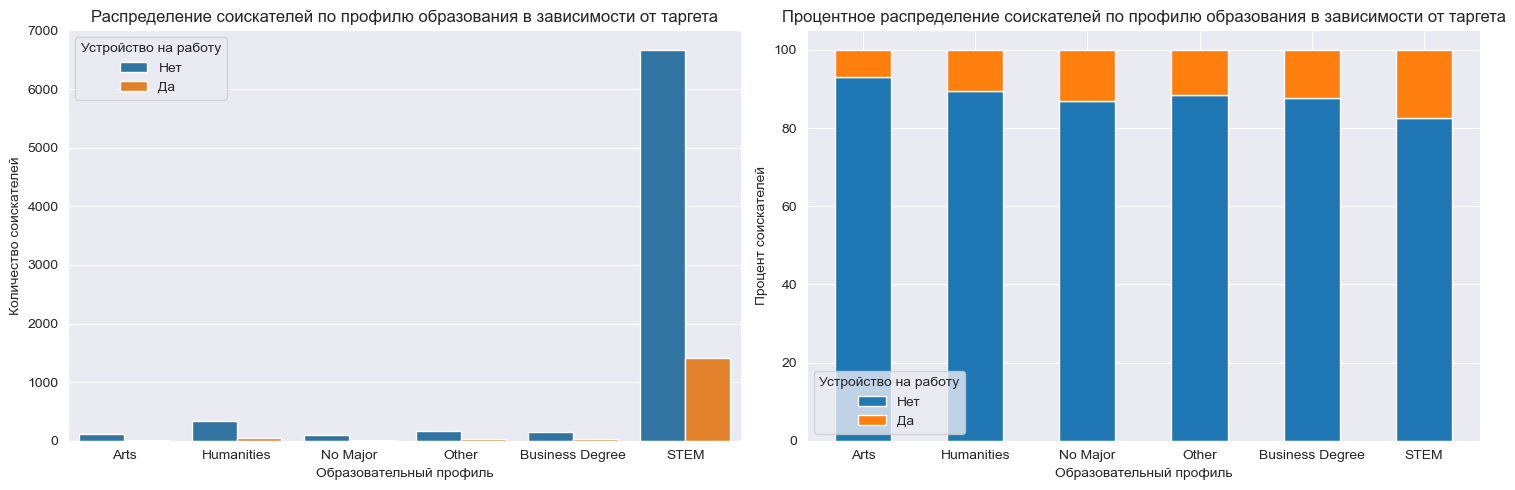

In [139]:
ordered_disciplines = ['Arts', 'Humanities', 'No Major', 'Other', 'Business Degree', 'STEM']
df['major_discipline'] = pd.Categorical(df['major_discipline'], categories=ordered_disciplines, ordered=True)

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
sns.countplot(x='major_discipline', hue='target', data=df)
plt.title('Распределение соискателей по профилю образования в зависимости от таргета')
plt.xlabel('Образовательный профиль')
plt.ylabel('Количество соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.subplot(1, 2, 2)
relevent_exp = df.groupby(['major_discipline', 'target']).size().unstack(fill_value=0)
relevent_exp_percent = relevent_exp.div(relevent_exp.sum(axis=1), axis=0) * 100
relevent_exp_percent.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xticks(rotation=0)
plt.title('Процентное распределение соискателей по профилю образования в зависимости от таргета')
plt.xlabel('Образовательный профиль')
plt.ylabel('Процент соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.tight_layout()
plt.show()

Визуализация подтверждает здравый смысл. На позицию в сфере DS чаще берут людей, которые имеют образование в области естественных наук: математики компьютерных наук и т.п.


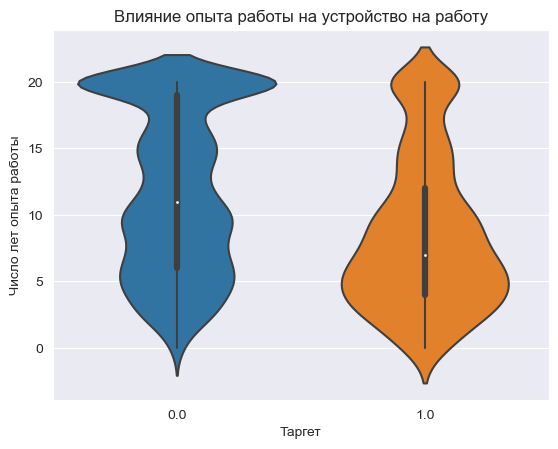

In [140]:
sns.violinplot(x='target', y='experience', data=df)

plt.title('Влияние опыта работы на устройство на работу')
plt.xlabel('Таргет')
plt.ylabel('Число лет опыта работы')

plt.show()

Интересный факт, что большинство соискателей, которых взяли на работу имеют опыт работы около пяти лет. 
Таким образом даже люди имеющие 20 и более лет опыта работы не гарантированно проходят на должность в Data Science, возможно что эти люди с большей трудностью усваивают новую информацию, что подталкивает работодателей нанимать более молодых кандидатов


### 6. Характеристики компании

In [141]:
list(df['company_size'].unique())

['50-99',
 '<10',
 '5000-9999',
 '1000-4999',
 '10/49',
 '100-500',
 '10000+',
 '500-999']

In [142]:
ordered_company_sizes = ['<10', '10/49', '50-99', '100-500', '500-999', '1000-4999', '5000-9999', '10000+']
df['company_size'] = pd.Categorical(df['company_size'], categories=ordered_company_sizes, ordered=True) 
company_size_counts = df['company_size'].value_counts().reindex(ordered_company_sizes)

In [143]:
list(df['company_type'].unique())

['Pvt Ltd',
 'Funded Startup',
 'Early Stage Startup',
 'Other',
 'Public Sector',
 'NGO']

In [144]:
ordered_company_types = ['NGO', 'Public Sector', 'Other', 'Early Stage Startup', 'Funded Startup', 'Pvt Ltd']
df['company_type'] = pd.Categorical(df['company_type'], categories=ordered_company_types, ordered=True)
company_type_counts = df['company_type'].value_counts().reindex(ordered_company_types)

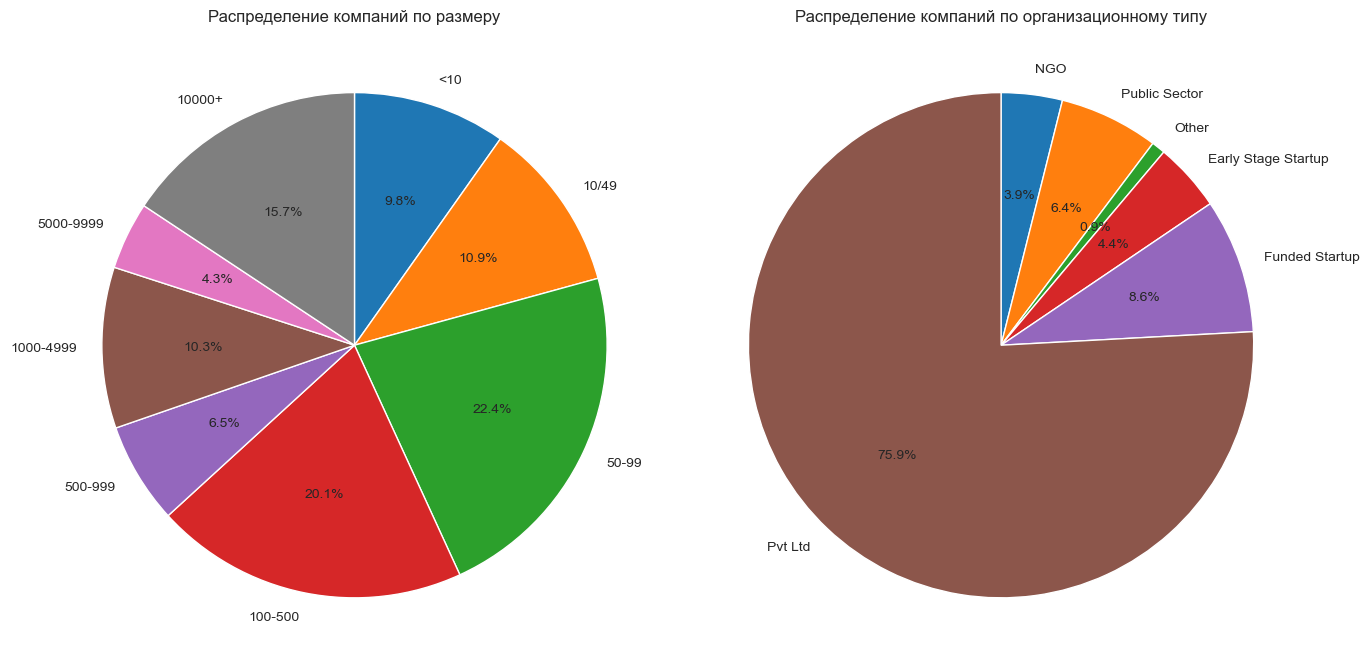

In [145]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.pie(company_size_counts, labels=company_size_counts.index, autopct='%1.1f%%', startangle=90,  counterclock=False)
plt.title('Распределение компаний по размеру')

plt.subplot(1, 2, 2)
plt.pie(company_type_counts, labels=company_type_counts.index, autopct='%1.1f%%', startangle=90,  counterclock=False)
plt.title('Распределение компаний по организационному типу')

plt.tight_layout()
plt.show()

В целом на рынке представлены самые разные по размеру компании. 
Треть всего рынка работодателей в сфере анализа данных представляют общества с ограниченной ответственностью (ООО), оставшуюся долю занимают стартапы, некоммерческие организации и т.п

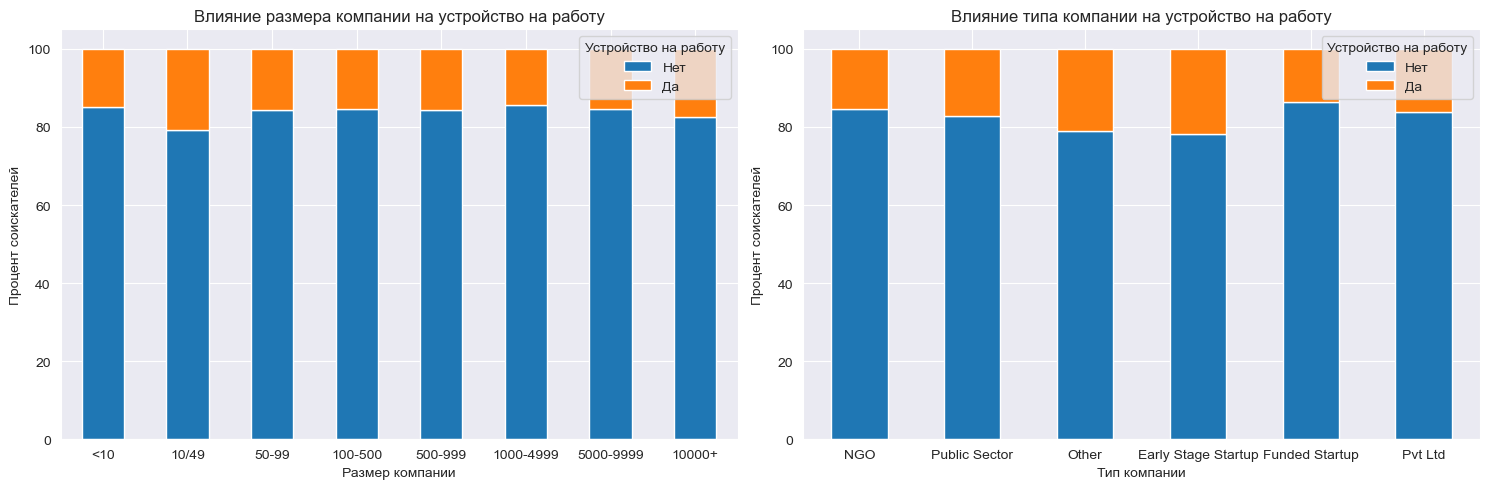

In [146]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
company_size = df.groupby(['company_size', 'target']).size().unstack(fill_value=0)
company_size_percent = company_size.div(company_size.sum(axis=1), axis=0) * 100
company_size_percent.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xticks(rotation=0)
plt.title('Влияние размера компании на устройство на работу')
plt.xlabel('Размер компании')
plt.ylabel('Процент соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.subplot(1, 2, 2)
company_type = df.groupby(['company_type', 'target']).size().unstack(fill_value=0)
company_type_percent = company_type.div(company_type.sum(axis=1), axis=0) * 100
company_type_percent.plot(kind='bar', stacked=True, ax=plt.gca())
plt.xticks(rotation=0)
plt.title('Влияние типа компании на устройство на работу')
plt.xlabel('Тип компании')
plt.ylabel('Процент соискателей')
plt.legend(title='Устройство на работу', labels=['Нет', 'Да'])

plt.tight_layout()
plt.show()

Анализируй оба графика, можно прийти к выводу о том что стартапы чаще чем другие компании принимают соискателя на работу, об этом же говорит перекос в размере компаний. Возможно, это происходит потому что в стартапы идут работать не за деньги а за идею, таким образом большинство соискателей которые захотели устроиться в стартап пошли туда не столько из-за денег сколько для опыта и идеи, а стартап не может предложить достойную оплату до тех пор пока он не финансируется.

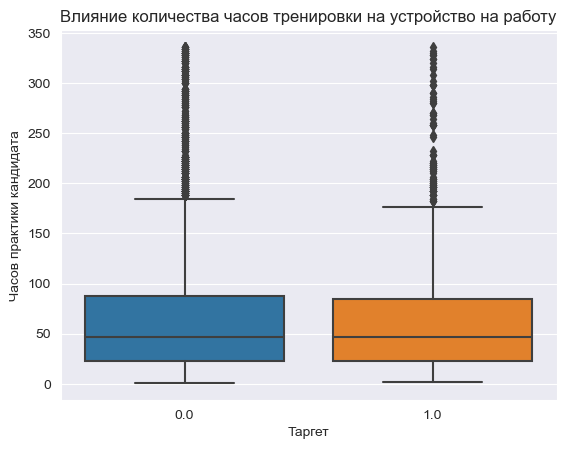

In [147]:
sns.boxplot(x='target', y='training_hours', data=df)

plt.title('Влияние количества часов тренировки на устройство на работу')
plt.xlabel('Таргет')
plt.ylabel('Часов практики кандидата')

plt.show()

По всей видимости количество часов практики при устройстве на работу практически не влияет на исход подачи на позицию

# Гипотезы

### 1. Опыт

Для начала проверим гипотезу о том что наличие релевантного опыта работы влияет на устройство на новую позицию, потому что предыдущий анализ показал что те кандидаты, которые не имеют опыта работы, чаще устраиваются на позицию в дата саенс. Будем использовать хи-квадрат тест поскольку наличие релевантного опыта является бинарной величиной

- **Нулевая гипотеза (H0):** Вероятность устройства на работу не зависит от наличия релевантного опыта.
- **Альтернативная гипотеза (H1):** Вероятность устройства на работу зависит от наличия релевантного опыта.

Зафиксируем уровень доверия = 95%


In [148]:
contingency_table = pd.crosstab(df['relevent_experience'], df['target'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

p_value # < 0.05

0.00012968335783641925

Удивительно но различия являются статистически значимыми при уровне доверия 95%. 
Кажется что компании хотят обучать с нуля своих специалистов, и им не выгодно переплачивать за кандидатов, которые имеют опыт и просят более высокую зарплату

### 2. Развитие города

Ещё один неочевидный момент: мы сделали вывод о том что уровень развития города влияет на принятие решений работодателей, проверим это

- **Нулевая гипотеза (H0):** Средний уровень развития города у тех, кто устроился на работу, не отличается от тех, кто не устроился.
- **Альтернативная гипотеза (H1):** Средний уровень развития города у тех, кто устроился на работу, отличается от тех, кто не устроился.

Зафиксируем уровень доверия = 95%

In [149]:
city_dev_index_hired = df[df['target'] == 1]['city_development_index'].dropna()
city_dev_index_not_hired = df[df['target'] == 0]['city_development_index'].dropna()

t_stat, p_value = stats.ttest_ind(city_dev_index_hired, city_dev_index_not_hired, equal_var=False)

p_value # << 0.05

3.52768753296034e-192

Уровень развития города, в котором проживает кандидат, определённо влияет на факт того что его намёт компания

### 3. Уровень образования

Исследуем влияет ли уровни образования кандидата на вероятность прохождения на позицию в DS

- **Нулевая гипотеза (H0):** Вероятность устройства на работу не зависит от уровня образования.
- **Альтернативная гипотеза (H1):** Вероятность устройства на работу зависит от уровня образования.

Зафиксируем уровень доверия = 95%

In [150]:
contingency_table = pd.crosstab(df['education_level'], df['target'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

p_value # < 0.05

1.1888018451617752e-05

Всё-таки устроиться на работу после получения бакалаврской степени более реалистично, чем попасть на работу до окончания вуза

### 4. Профиль обучения

То же самое проверим для профиля соискателя: на самом деле ли образование в сфере естественных наук повышает шансы принятия на работу в машинном обучении?

- **Нулевая гипотеза (H0):** Вероятность устройства на работу не зависит от специализации кандидата.
- **Альтернативная гипотеза (H1):** Вероятность устройства на работу зависит от специализации кандидата.

Зафиксируем уровень доверия = 95%

In [151]:
contingency_table = pd.crosstab(df['major_discipline'], df['target'])

chi2, p_value, dof, expected = stats.chi2_contingency(contingency_table)

p_value # < 0.05

2.8433162057792902e-05

Ничего неожиданного: получив высшее образование в области математики действительно легче устроиться на позицию дата саентиста, чем окончив вуз по специальности изобразительное искусство (может быть с дизайном дела обстоят по-другому)


# Машинное обучение

### 1. Логистическая регрессия

Обучим обыкновенную логистическую регрессию чтобы предсказывать факт принятия кандидата на работу 

In [152]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)

Напишем функцию для оценки метрик моделей

In [153]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, roc_auc

In [154]:
train_metrics = evaluate_model(y_train, y_train_pred)
test_metrics = evaluate_model(y_test, y_test_pred)

print(f"Логистическая регрессия на тренировочных данных: \nAccuracy: {train_metrics[0]}\nPrecision: {train_metrics[1]}\nRecall: {train_metrics[2]} \nF1:{train_metrics[3]}\nROC AUC: {train_metrics[4]}")
print('')
print(f"Логистическая регрессия на тестовых данных: \nAccuracy: {test_metrics[0]}\nPrecision: {test_metrics[1]}\nRecall: {test_metrics[2]}\nF1: {test_metrics[3]}\nROC AUC: {test_metrics[4]}")

Логистическая регрессия на тренировочных данных: 
Accuracy: 0.8615205019699401
Precision: 0.5997596153846154
Recall: 0.4475336322869955 
F1:0.5125834617360041
ROC AUC: 0.6947497370218526

Логистическая регрессия на тестовых данных: 
Accuracy: 0.8539823008849557
Precision: 0.5656836461126006
Recall: 0.44142259414225943
F1: 0.49588719153936545
ROC AUC: 0.687784467802837


### 2. Ridge

Теперь применим L-2 регулизацию, чтобы штрафовать модель за слишком большие веса

In [155]:
ridge_log_reg = LogisticRegression(penalty='l2', max_iter=1000)
ridge_log_reg.fit(X_train, y_train)

y_train_pred_ridge = ridge_log_reg.predict(X_train)
y_test_pred_ridge = ridge_log_reg.predict(X_test)

In [156]:
ridge_train_metrics = evaluate_model(y_train, y_train_pred_ridge)
ridge_test_metrics = evaluate_model(y_test, y_test_pred_ridge)

print(f"Логистическая регрессия c L-2 регуляризацией на тренировочных данных: \nAccuracy: {ridge_train_metrics[0]}\nPrecision: {ridge_train_metrics[1]}\nRecall: {ridge_train_metrics[2]} \nF1:{ridge_train_metrics[3]}\nROC AUC: {ridge_train_metrics[4]}")
print('')
print(f"Логистическая регрессия c L-2 регуляризацией на тестовых данных: \nAccuracy: {ridge_test_metrics[0]}\nPrecision: {ridge_test_metrics[1]}\nRecall: {ridge_test_metrics[2]}\nF1: {ridge_test_metrics[3]}\nROC AUC: {ridge_test_metrics[4]}")

Логистическая регрессия c L-2 регуляризацией на тренировочных данных: 
Accuracy: 0.8615205019699401
Precision: 0.5997596153846154
Recall: 0.4475336322869955 
F1:0.5125834617360041
ROC AUC: 0.6947497370218526

Логистическая регрессия c L-2 регуляризацией на тестовых данных: 
Accuracy: 0.8539823008849557
Precision: 0.5656836461126006
Recall: 0.44142259414225943
F1: 0.49588719153936545
ROC AUC: 0.687784467802837


Можем заметить, что регулизация никак не изменила модель логистической регрессии и не повлияла на метрике её качества. 
Попробуем применить L-1 регуляцию, чтобы избавиться от неинформативных признаков и улучшить качество модели

### 3. Lasso

In [157]:
lasso_log_reg = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
lasso_log_reg.fit(X_train, y_train)

y_train_pred_lasso = lasso_log_reg.predict(X_train)
y_test_pred_lasso = lasso_log_reg.predict(X_test)

In [158]:
lasso_train_metrics = evaluate_model(y_train, y_train_pred_lasso)
lasso_test_metrics = evaluate_model(y_test, y_test_pred_lasso)

print(f"Логистическая регрессия c L-1 регуляризацией на тренировочных данных: \nAccuracy: {lasso_train_metrics[0]}\nPrecision: {lasso_train_metrics[1]}\nRecall: {lasso_train_metrics[2]} \nF1:{lasso_train_metrics[3]}\nROC AUC: {lasso_train_metrics[4]}")
print('')
print(f"Логистическая регрессия c L-1 регуляризацией на тестовых данных: \nAccuracy: {lasso_test_metrics[0]}\nPrecision: {lasso_test_metrics[1]}\nRecall: {lasso_test_metrics[2]}\nF1: {lasso_test_metrics[3]}\nROC AUC: {lasso_test_metrics[4]}")

Логистическая регрессия c L-1 регуляризацией на тренировочных данных: 
Accuracy: 0.8615205019699401
Precision: 0.5990453460620525
Recall: 0.45022421524663675 
F1:0.5140809011776752
ROC AUC: 0.6958336133744512

Логистическая регрессия c L-1 регуляризацией на тестовых данных: 
Accuracy: 0.85500340367597
Precision: 0.5698924731182796
Recall: 0.4435146443514644
F1: 0.49882352941176467
ROC AUC: 0.6892369969724801


Новая модель показала лучше скоры по сравнению с предыдущими

### 4. Важность признаков

Посмотрим на то, какие признаки внесли наибольший вклад в модель

In [159]:
lasso_log_reg.coef_

array([[-0.4235001 , -0.1767977 , -0.01957304,  0.34503011,  0.37361337,
         0.40105003, -0.0975542 , -0.19201825,  1.54153774,  0.12539877,
        -0.42294123, -0.39350632, -0.20226349,  0.        ,  0.        ,
        -0.04409765,  0.83586738,  0.        ,  1.81028605,  0.        ,
        -0.00428731, -0.40468726,  0.90893971, -0.06809066,  0.        ,
         0.        ,  0.        ,  0.        , -0.39038545, -0.16774773,
         0.09690364, -0.00282763,  0.09688315,  1.25191207,  0.0118006 ,
         0.04771785, -0.63279716,  0.        ,  0.        ,  0.        ,
         0.25134108,  0.004838  ,  0.04994746,  0.243228  , -0.07111798,
        -0.11026656, -0.07336893, -0.07184219,  0.30524904,  0.09598066,
         0.        ,  0.40750147,  0.20874909, -0.03968482,  0.12339702,
        -0.40626621, -0.15554107, -0.18053701, -0.35922515, -0.37511729,
        -0.25763083, -0.27740071, -0.0161288 ,  0.03107288,  0.46917942,
         0.4145773 ,  0.        ]])

In [161]:
lasso_coefficients = pd.DataFrame({'Признак': X_train.columns, 'Вес': lasso_log_reg.coef_.tolist()[0]})
lasso_coefficients_sorted = lasso_coefficients.sort_values(by='Вес', ascending=False)
lasso_coefficients_sorted

,Признак,Вес
18,city_city_21,1.810286
8,city_city_11,1.541538
33,city_city_74,1.251912
22,city_city_41,0.908940
16,city_city_162,0.835867
...,...,...
21,city_city_36,-0.404687
55,company_size_100-500,-0.406266
10,city_city_116,-0.422941
0,city_development_index,-0.423500


Одним из наиболее определяющих признаков для модели является принадлежность кандидата конкретному городу